## Supervised Machine Learning, Regression - final project

## Summary
The dataset for this project was collected from <a href="https://www.kaggle.com/datasets/mirichoi0218/insurance" target="_blank">Kaggle</a> and concerns health insurance. It describes various parameters that make it possible to characterize an insurance, as well as its final cost.<br>
In this case, the task will be to predict the final price of the insurance using the given data. Therefore, instead of focusing on the interpretability of the model, importance will be given to the accuracy of the prediction.<br>

The dataset has 1338 instances and 7 attributes.<br><br>
Let's take a more detailed look at the attributes:<br>

<ol>
<li>age: age of primary beneficiary</li>
<li>sex: insurance contractor gender, female, male</li>
<li>bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight(kg/m  2 ) using the ratio of height to weight, ideally 18.5 to 24.9</li>
<li>children: Number of children covered by health insurance / Number of dependents</li>
<li>smoker: Smoking</li>
<li>region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.</li>
<li>charges: Individual medical costs billed by health insurance</li>
</ol>

<br>
Since the goal of this project is to predict the final price of the insurance, the 'charges' column will be the label of the dataset.

For this project it was used Visual Studio Code with a custom environment, equipped with the Jupyter notebook and Python 3.7.10

## Exploratory Data Analysis and Preprocessing

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import  r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,LabelEncoder
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet 
from sklearn.pipeline import Pipeline

In [2]:
# Mute the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('./insurance.csv', sep=',')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.shape

(1338, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


It is clear that there are three categorical features and four numerical ones. Some Encoding will be necessary later.

In [6]:
data.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [7]:
# Checking for null values
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Luckily, there are no null values. Starting from this, let's take a closer look to the unique values of the categorical features to better understand the domain of them all.

In [8]:
cat_features = ['sex', 'smoker', 'region']
data_cat = data[cat_features]

for col in data_cat:
    print(col + ': ')
    print(data_cat[col].unique())

sex: 
['female' 'male']
smoker: 
['yes' 'no']
region: 
['southwest' 'southeast' 'northwest' 'northeast']


Text(0.5, 1.0, 'Region')

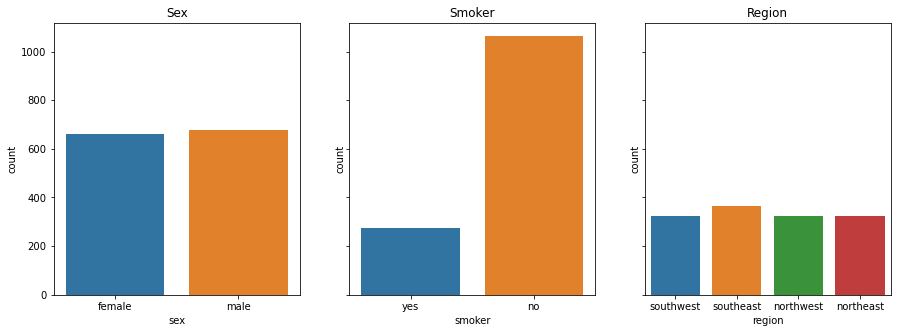

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.countplot(x="sex", data=data_cat, ax=axes[0])
axes[0].set_title("Sex")

sns.countplot(x="smoker", data=data_cat, ax=axes[1])
axes[1].set_title("Smoker")

sns.countplot(x="region", data=data_cat, ax=axes[2])
axes[2].set_title("Region")

For a start, we will encode these categorical features.

In [10]:
# sex , smoker , region
for col in cat_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In general, categorical variables with large variability are best encoded using OneHotEncoder. In this case, since there is no logical order in the region column, it can be also used the LabelEncoder. With this choice we can more easily see a correlation between regions and charges.

In [11]:
data.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


<AxesSubplot:>

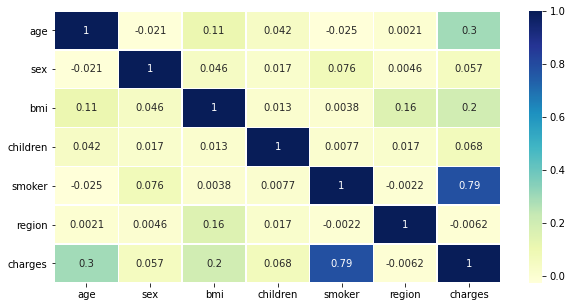

In [12]:
corr = data.corr(method='pearson')
fig = plt.subplots(figsize = (10, 5))
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='YlGnBu',
            annot=True,
            linewidth=0.5)

We can observate, as expected, a strong correlation between the smoking factor and the final charge.<br>
It is interesting to see how much being a smoker affects the value of the charge.

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

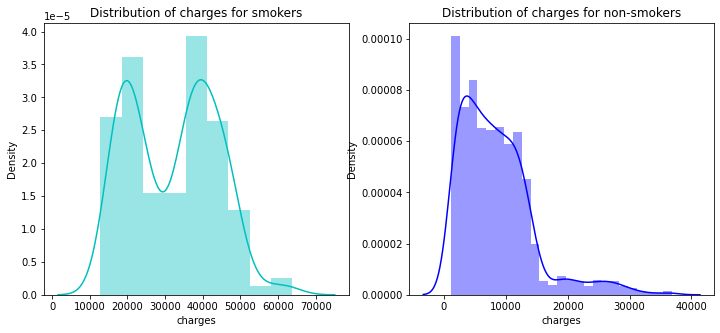

In [13]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(data[(data.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('Distribution of charges for non-smokers')

As expected, being a smoker implies much higher costs.

## Train-Test Split
In this phase, the dataset is splitted into two parts: one for the training and one for the test.

In [14]:
x = data.drop(['charges'], axis = 1)
y = data.charges

X_train,X_test,y_train,y_test = train_test_split(x, y, test_size = 0.25, random_state = 15)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1003 samples.
Testing set has 335 samples.


## Train Models
In this paragraph we will train various Machine Learning models: Vanilla Linear, Ridge, Lasso, ElasticNet.
On each of these models will then be done the tuning of the hyperparameters, which will allow to find the best values that will be th input for the training of the best estimators.
At the end, the results will be compared using the R2 metric.

In [15]:
# Cross Validation
kf = KFold(shuffle=True, random_state = 123, n_splits = 10)     # 10 folds

In [16]:
# Scaler
s = StandardScaler()

Vanilla Linear Regression

In [17]:
# Vanilla Linear Regression
lr = LinearRegression()

estimator = Pipeline([
                    ("scaler", s),
                    ("regression", lr)
                    ])
                    
y_pred_linear = cross_val_predict(estimator, X_train, y_train, cv = kf)
linear_score = r2_score(y_train, y_pred_linear)

#score
print(linear_score)

0.734100569691711


Lasso Regression

Text(0, 0.5, '$R^2$')

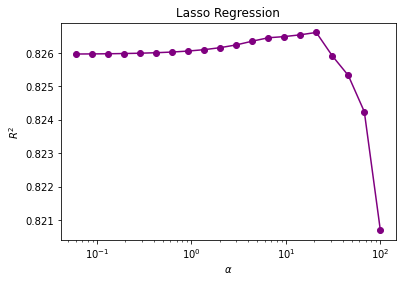

In [18]:
# Lasso Regression
pf = PolynomialFeatures(degree=2)

scores = []
alphas = np.geomspace(0.06, 100.0, 20)
y_pred_lasso = []

for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
                        ("make_higher_degree", pf),
                        ("scaler", s),        
                        ("lasso_regression", las)
                        ])

    y_pred_lasso = cross_val_predict(estimator, X_train, y_train, cv = kf)    
    
    score = r2_score(y_train, y_pred_lasso)    
    scores.append(score)

plt.semilogx(alphas, scores, '-o', color='purple')
plt.title('Lasso Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$')

In [19]:
results = dict(zip(alphas, scores))

max_value = list(results.values())
max_key = list(results.keys())

best_alpha_lasso = max_key[max_value.index(max(max_value))]

print("Best Alpha: ")
print(best_alpha_lasso)

Best Alpha: 
20.97568018398887


In [20]:
best_estimator = Pipeline([
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("scaler", s),                    
                    ("lasso_regression", Lasso(alpha=best_alpha_lasso))
                    ])

best_estimator.fit(X_train, y_train)
lasso_score = best_estimator.score(X_train, y_train)
print(lasso_score)

0.8337387726487913


Ridge Regression

Text(0, 0.5, '$R^2$')

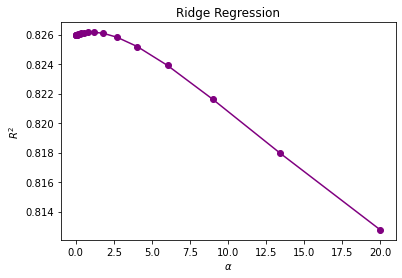

In [21]:
# Ridge Regression
pf = PolynomialFeatures(degree=2)

alphas = np.geomspace(0.01, 20.0, 20)
scores=[]
y_pred_ridge = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([        
                        ("polynomial_features", pf),
                        ("scaler", s),
                        ("ridge_regression", ridge)
                        ])

    y_pred_ridge = cross_val_predict(estimator, X_train, y_train, cv = kf)
    
    score = r2_score(y_train, y_pred_ridge)
    scores.append(score)

plt.plot(alphas, scores, '-o', color='purple')
plt.title('Ridge Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$')

In [22]:
results = dict(zip(alphas, scores))

max_value = list(results.values())
max_key = list(results.keys())

best_alpha_ridge = max_key[max_value.index(max(max_value))]

print("Best Alpha: ")
print(best_alpha_ridge)

Best Alpha: 
1.2157969509318967


In [23]:
best_estimator = Pipeline([
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("scaler", s),                    
                    ("ridge_regression", Ridge(alpha=best_alpha_ridge))
                    ])

best_estimator.fit(X_train, y_train)
ridge_score = best_estimator.score(X_train, y_train)
print(ridge_score)

0.8354286071604017


In [24]:
# comparing scores
pd.DataFrame([[linear_score, lasso_score, ridge_score]], columns=['Linear', 'Lasso', 'Ridge'], index=['score'])

,Linear,Lasso,Ridge
score,0.734101,0.833739,0.835429


<b>Conclusion 1: </b><br>
We can notice, once the best hyperparameters have been selected, that both Lasso and Ridge give better results than Vanilla Linear Regression!<br>
It is also interesting to compare the results of the execution times in finding best hyperparameters for the various algorithms. In fact, Lasso took over a minute and a half to run, while the others took only a few seconds.

ElasticNet

In this case, I would like to use a different approach.<br>
Instead of manually selecting hyperparameters, I will use the GridSearch to find them. After that, I will use these parameters as input for the best estimator and I will compare the result with previous ones.

In [25]:
el = ElasticNet()
el_param_grid = {'alpha' : [  0.99 ,0.1, 0.12 , 1 ],
                  'l1_ratio' :[ 0.0001, 0.01,0.05,0.4 ,0.5,0.6,0.8,0.99 ]}
                  
# l1_ratio corresponds to the mix ratio r               
# when l1_ratio = 0 , Elastic Net is equivalent to Ridge Regression
# when l1_ratio = 1, it is equivalent to Lasso Regression                  
gsElN = GridSearchCV(el, param_grid = el_param_grid, cv = kf, scoring = "r2", n_jobs= 4, verbose = 1)

gsElN.fit(X_train, y_train)

el_best = gsElN.best_estimator_
el_best

Fitting 10 folds for each of 32 candidates, totalling 320 fits


ElasticNet(alpha=0.12, l1_ratio=0.99)

In [26]:
best_estimator = Pipeline([
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("scaler", s),                    
                    ("elastic_net_regression", ElasticNet(random_state = 21, alpha = el_best.alpha, l1_ratio = el_best.l1_ratio))
                    ])

best_estimator.fit(X_train, y_train)
elastic_net_score = best_estimator.score(X_train, y_train)
print(elastic_net_score)

0.8354389935152462


In [27]:
# comparing scores
pd.DataFrame([[linear_score, lasso_score, ridge_score, elastic_net_score]], columns=['Linear', 'Lasso', 'Ridge', 'ElasticNet'], index=['score'])

,Linear,Lasso,Ridge,ElasticNet
score,0.734101,0.833739,0.835429,0.835439


<b>Conclusion 2: </b><br>
It is clear that also ElasticNet performs better than Vanilla Linear Regression. We can also notice that its results are comparable with the ones obtained with Lasso and Ridge.<br>
In the end, even in this case, the best performing model is Ridge. It has excellent performances and required modest execution times.

## Next Steps
Despite the interesting results, we can go even further with this project.<br>
In fact, GridSearch can also be used to find the Lasso and Ridge hyperparameters.<br>
Furthermore, we can consider using other comparison metrics, such as the MSE or RMSE, to evaluate the goodness of the various models.

<div style="text-align: right"> Raffaele Pane </div>